In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sc.set_figure_params(dpi=200, frameon=False, figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata = sc.read('../pbmc_kang/pbmc_vars_sb.h5ad')

In [6]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [9]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
sc.pp.normalize_total(adata)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [13]:
select_terms = adata.varm['I'].sum(0)>12

In [14]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [15]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [16]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [17]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [19]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 4
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [20]:
ALPHA = 0.7

In [21]:
OMEGA = None

In [22]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██████████----------| 51.5%  - epoch_loss:  875.30 - epoch_recon_loss:  852.80 - epoch_kl_loss:   45.00 - val_loss:  934.38 - val_recon_loss:  911.03 - val_kl_loss:   46.70
ADJUSTED LR
 |████████████--------| 62.3%  - epoch_loss:  874.46 - epoch_recon_loss:  852.00 - epoch_kl_loss:   44.93 - val_loss:  932.14 - val_recon_loss:  909.08 - val_kl_loss:   46.13
ADJUSTED LR
 |█████████████-------| 68.0%  - epoch_loss:  871.68 - epoch_recon_loss:  849.26 - epoch_kl_loss:   44.85 - val_loss:  931.21 - val_recon_loss:  908.10 - val_kl_loss:   46.21
ADJUSTED LR
 |██████████████------| 71.2%  - epoch_loss:  875.08 - epoch_recon_loss:  852.61 - epoch_kl_loss:   44.94 - val_loss:  932.23 - val_recon_loss:  909.14 - val_kl_loss:   46.20
ADJUSTED LR
 |██████████████------| 74.5%  - epoch_loss:  869.83 - epoch_recon_loss:  847.42 - epoch_kl_loss:   44.83 - val_loss:  934.64 - val_recon_loss:  911.49 - val_kl_loss:   46.30
ADJUSTED LR
 |███████████████-----| 77.2%  - epoch_loss:  870.36 - epoch_reco

In [23]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [24]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'DAG_AND_IP3_SIGNALING',
 'GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'ACTIVATED_NOTCH1_TRANSMITS_SIG',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SIGNALLING_TO_RAS',
 'HEPARAN_SULFATE_HEPARIN_HS_GAG',
 'SIGNALING_BY_FGFR_MUTANTS',
 'BASIGIN_INTERACTIONS',
 'ERK_MAPK_TARGETS',
 'TRANSPORT_OF_MATURE_TRANSCRIPT',
 'NRAGE_SIGNALS_DEATH_THROUGH_JN',
 'REGULATION_OF_APOPTOSIS',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'CA_DEPENDENT_EVENTS',
 'G1_PHASE',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'NUCLEOTIDE_EXCISION_REPAIR',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_BETA_GAMMA_SIGNALLING_THROUG',
 'CELL_JUNCTION_ORGANIZATION',
 'PI_3K_CASCADE',
 'TAK1_ACTIVATES_NFKB_BY_PHOSPHO',


In [25]:
MEAN = False

In [26]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [27]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [28]:
sc.tl.umap(adata)

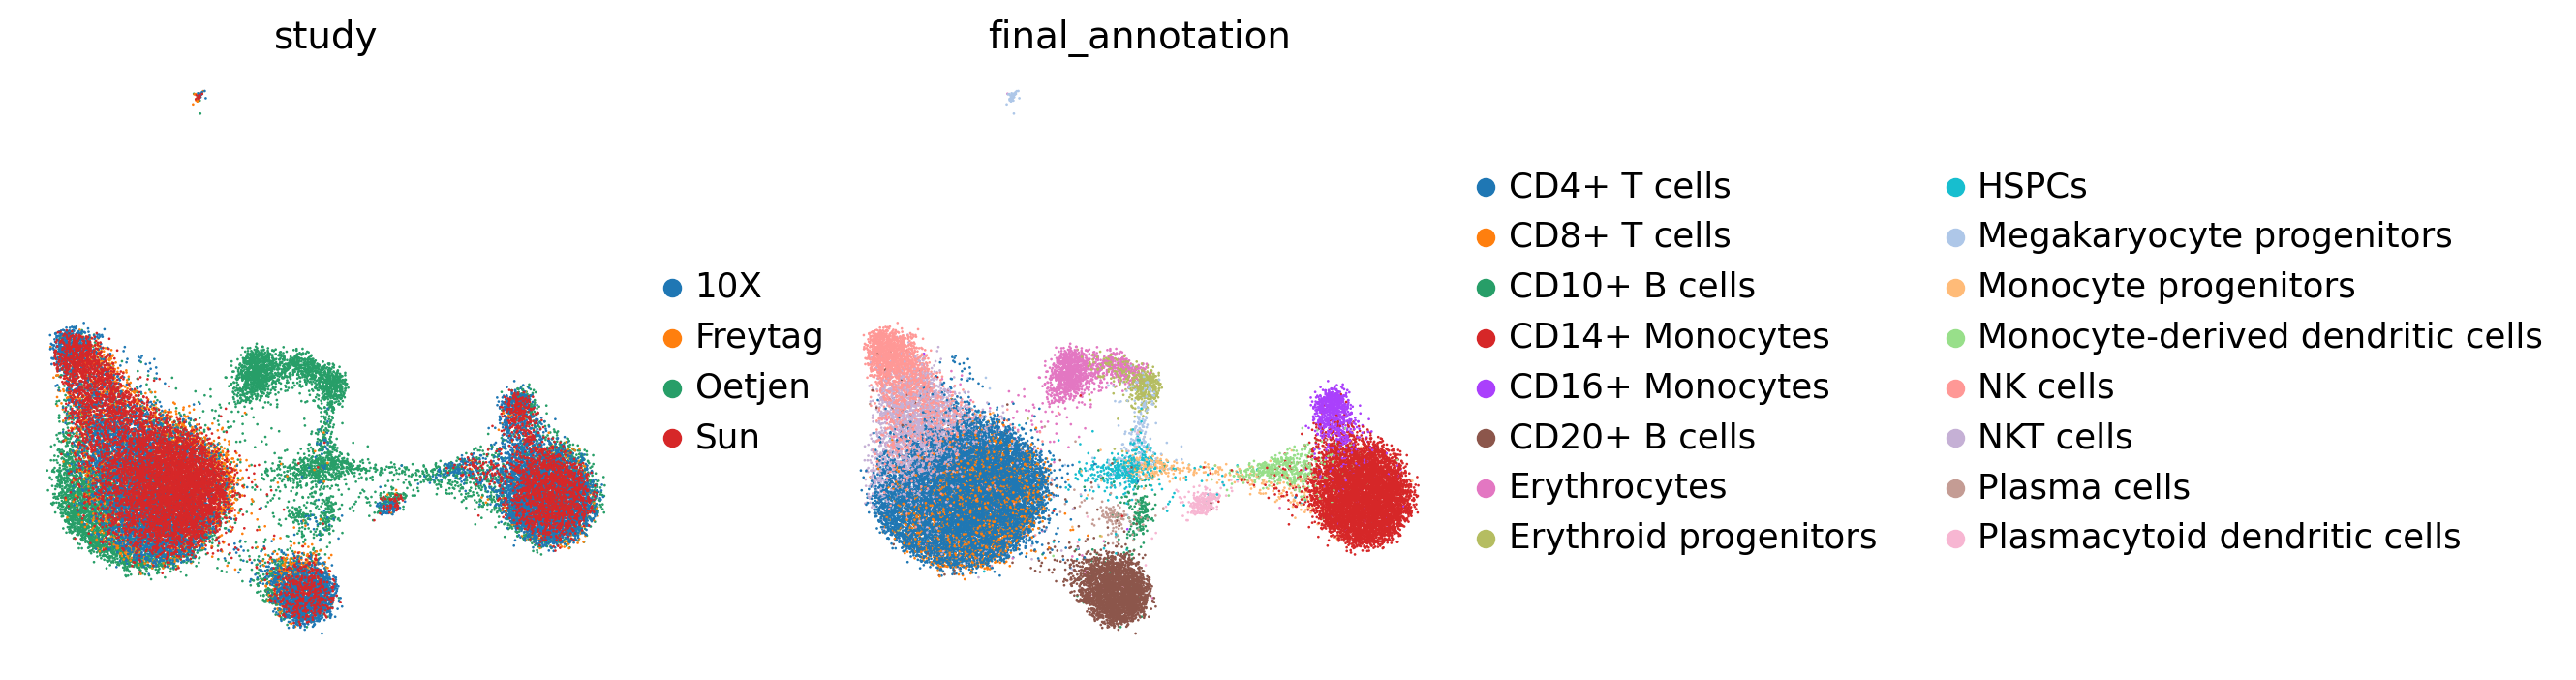

In [29]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [30]:
intr_cvae.save('./kang_reference')

In [319]:
covid = sc.read('covid_pbmc.h5ad')
covid.var_names_make_unique()
covid = covid[:, adata.var_names].copy()
covid.X = covid.X.toarray()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [320]:
covid.obs['study'] = "covid"

In [321]:
kang = sc.read('../pbmc_kang/kang_count.h5ad')[:, adata.var_names].copy()

In [322]:
kang.obs['study'] = 'Kang'

In [323]:
covid_kang = sc.AnnData.concatenate(covid, kang, batch_key='batch_join')

In [104]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [190]:
q_intr_cvae = sca.models.TRVAE.load_query_data(covid_kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 6
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Encoder Architecture:
	Input Layer in, out and cond: 1972 128 6
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 6


In [191]:
q_intr_cvae.train(n_epochs=200, alpha_epoch_anneal=50, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██████--------------| 30.0%  - epoch_loss:  529.08 - epoch_recon_loss:  523.09 - epoch_kl_loss:   59.90 - val_loss:  532.86 - val_recon_loss:  526.94 - val_kl_loss:   59.19
ADJUSTED LR
 |██████--------------| 34.0%  - epoch_loss:  529.74 - epoch_recon_loss:  523.76 - epoch_kl_loss:   59.72 - val_loss:  535.13 - val_recon_loss:  529.19 - val_kl_loss:   59.36
ADJUSTED LR
 |███████-------------| 37.5%  - epoch_loss:  531.34 - epoch_recon_loss:  525.35 - epoch_kl_loss:   59.94 - val_loss:  534.97 - val_recon_loss:  529.03 - val_kl_loss:   59.42
ADJUSTED LR
 |████████------------| 40.5%  - epoch_loss:  529.98 - epoch_recon_loss:  524.01 - epoch_kl_loss:   59.67 - val_loss:  533.78 - val_recon_loss:  527.85 - val_kl_loss:   59.31
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 59


In [210]:
q_intr_cvae.save('cvae_kang_covid_query')

In [324]:
covid_kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [325]:
sc.pp.neighbors(covid_kang, use_rep='X_cvae')

In [326]:
sc.tl.umap(covid_kang)

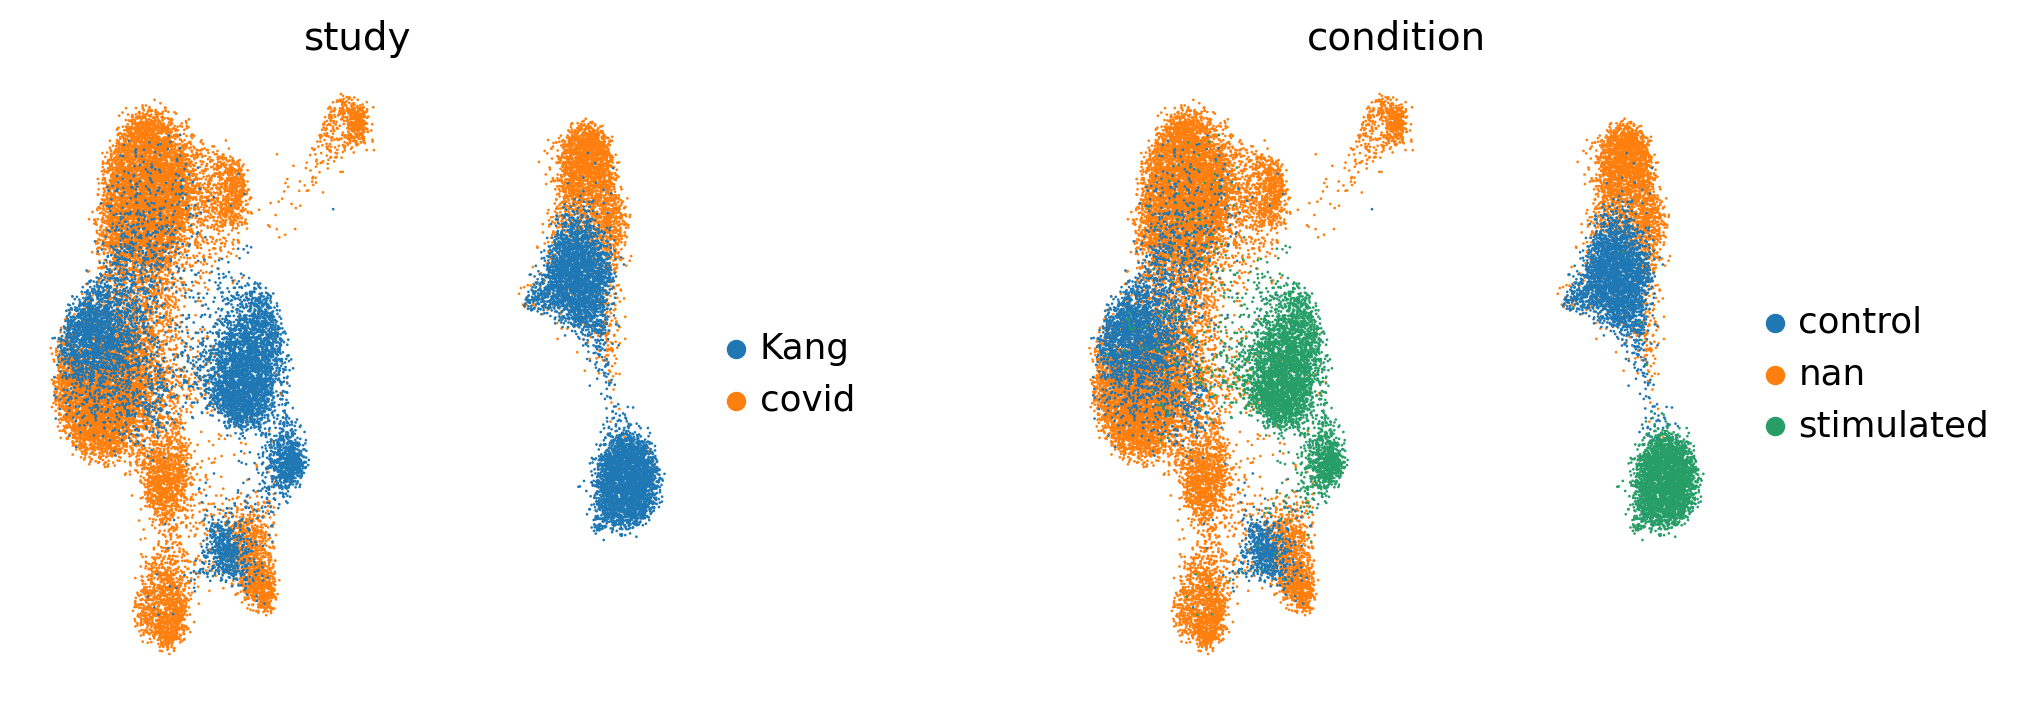

In [328]:
sc.pl.umap(covid_kang, color=['study', "condition"], wspace=0.4)

In [329]:
covid_pbmc = sc.AnnData.concatenate(adata, covid_kang, batch_key='batch_join')

In [330]:
covid_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(covid_pbmc.X, covid_pbmc.obs['study'], mean=MEAN)[:, ~inactive_idx]

In [331]:
sc.pp.neighbors(covid_pbmc, use_rep='X_cvae')
sc.tl.umap(covid_pbmc)

In [332]:
covid_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'batch2' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [333]:
covid_pbmc.obs['cell_type_joint'] = covid_pbmc.obs['final_annotation'].tolist()

In [334]:
covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs.study == 'Kang'] = covid_pbmc.obs.cell_type

In [335]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [336]:
categories = np.unique(covid_pbmc.obs['cell_type_joint'].astype(str))
for cat in categories:
    if cat in celltypes_replace:
        covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [337]:
from sklearn.ensemble import RandomForestClassifier

In [338]:
clf = RandomForestClassifier(
    random_state=1,
    class_weight = "balanced_subsample",
    verbose=1,
    n_jobs=-1,
)

mask_train = (covid_pbmc.obs.cell_type_joint != 'nan') & ~covid_pbmc.obs.cell_type_joint.isin(['DC', 'T'])
adata_train = covid_pbmc[mask_train]

X_train = adata_train.obsm['X_cvae']
y_train = adata_train.obs['cell_type_joint'].to_numpy()

clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=1, verbose=1)

In [339]:
covid_pbmc.obs.cell_type_joint.value_counts()

nan                                 18752
CD4+ T cells                        15277
CD14+ Monocytes                     10700
B                                    4239
CD8+ T cells                         2997
NK cells                             2913
NKT cells                            2745
CD16+ Monocytes                      1869
Erythrocytes                         1502
T                                     633
Monocyte-derived dendritic cells      478
HSPCs                                 473
DC                                    472
Erythroid progenitors                 463
Monocyte progenitors                  428
Megakaryocyte progenitors             270
Plasmacytoid dendritic cells          265
CD10+ B cells                         207
Plasma cells                          129
Name: cell_type_joint, dtype: int64

In [340]:
predict = clf.predict(covid_pbmc[covid_pbmc.obs.cell_type_joint == "nan"].obsm['X_cvae'])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


In [341]:
covid_pbmc.obs['cell_type_joint'][covid_pbmc.obs.cell_type_joint == "nan"] = predict

... storing 'cell_type_joint' as categorical


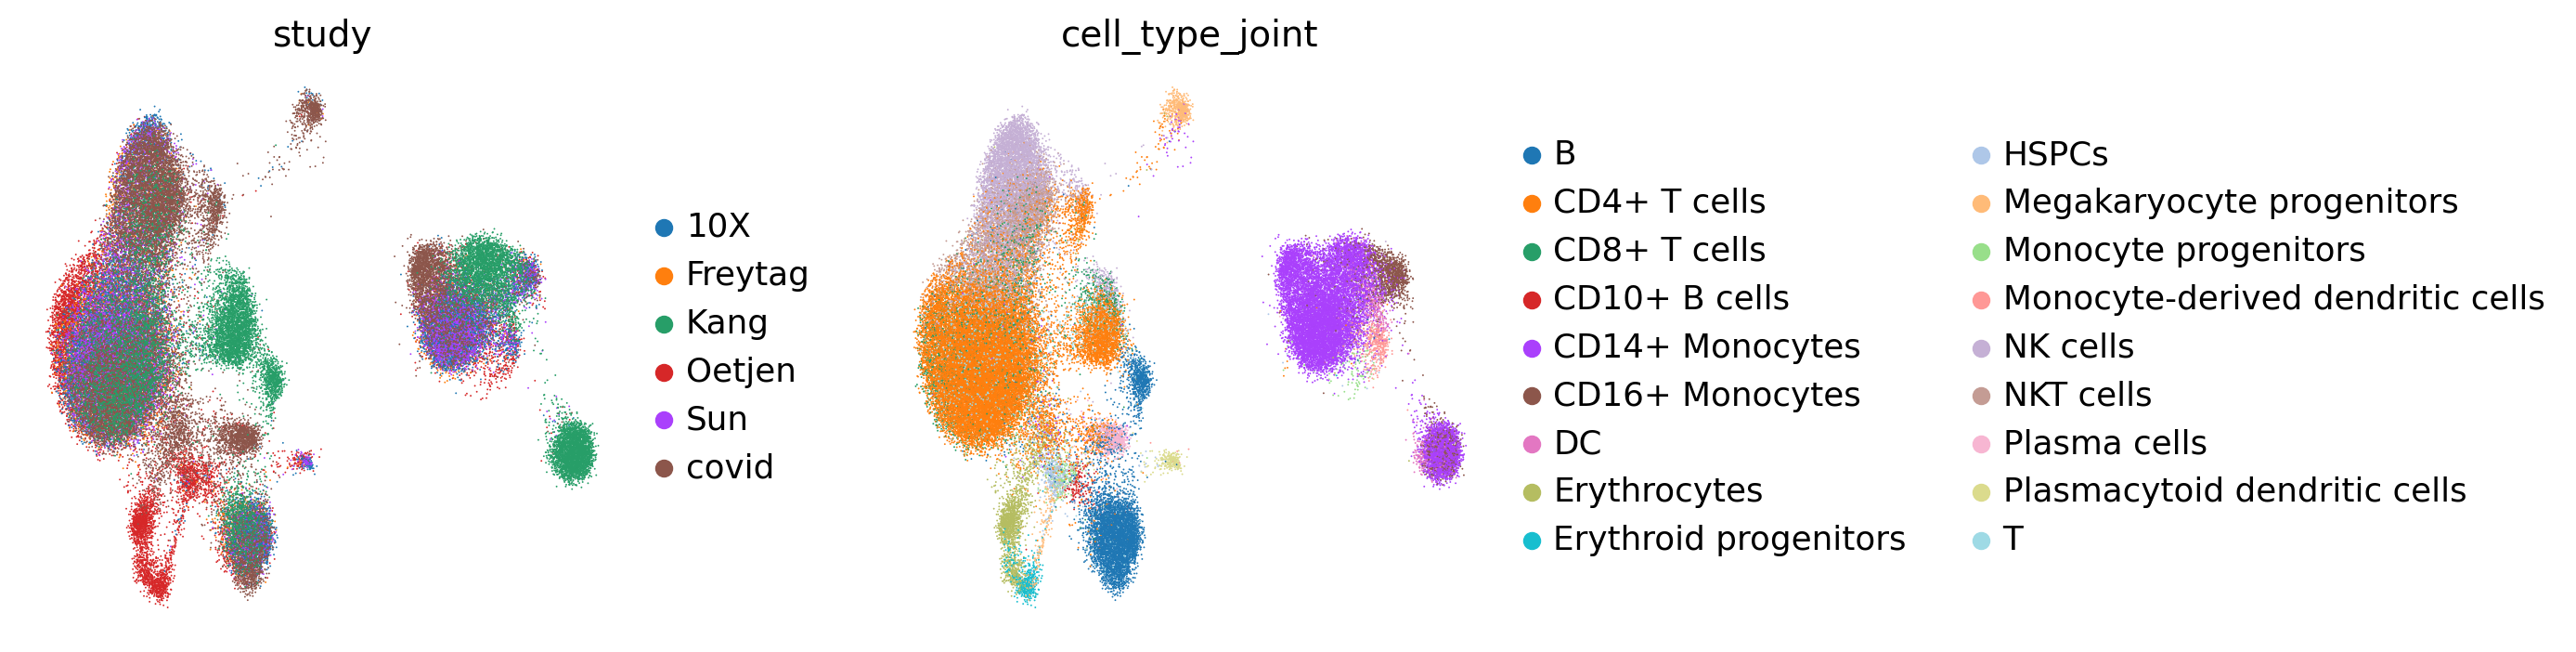

In [342]:
sc.pl.umap(covid_pbmc, color=['study', 'cell_type_joint'], wspace=0.3)

In [343]:
covid_pbmc.obs.batch.value_counts()

nan               13576
10X               10727
P1-day5-rep2       3851
Oetjen_U           3730
Freytag            3347
P2-day7            3332
Oetjen_P           3265
P1-day5-rep1       3129
P1-day1-rep1       2591
Oetjen_A           2586
Sun_sample4_TC     2420
Sun_sample3_TB     2403
Sun_sample2_KC     2281
P2-day1            2280
P1-day1-rep2       2081
Sun_sample1_CS     1725
P2-day5            1488
Name: batch, dtype: int64

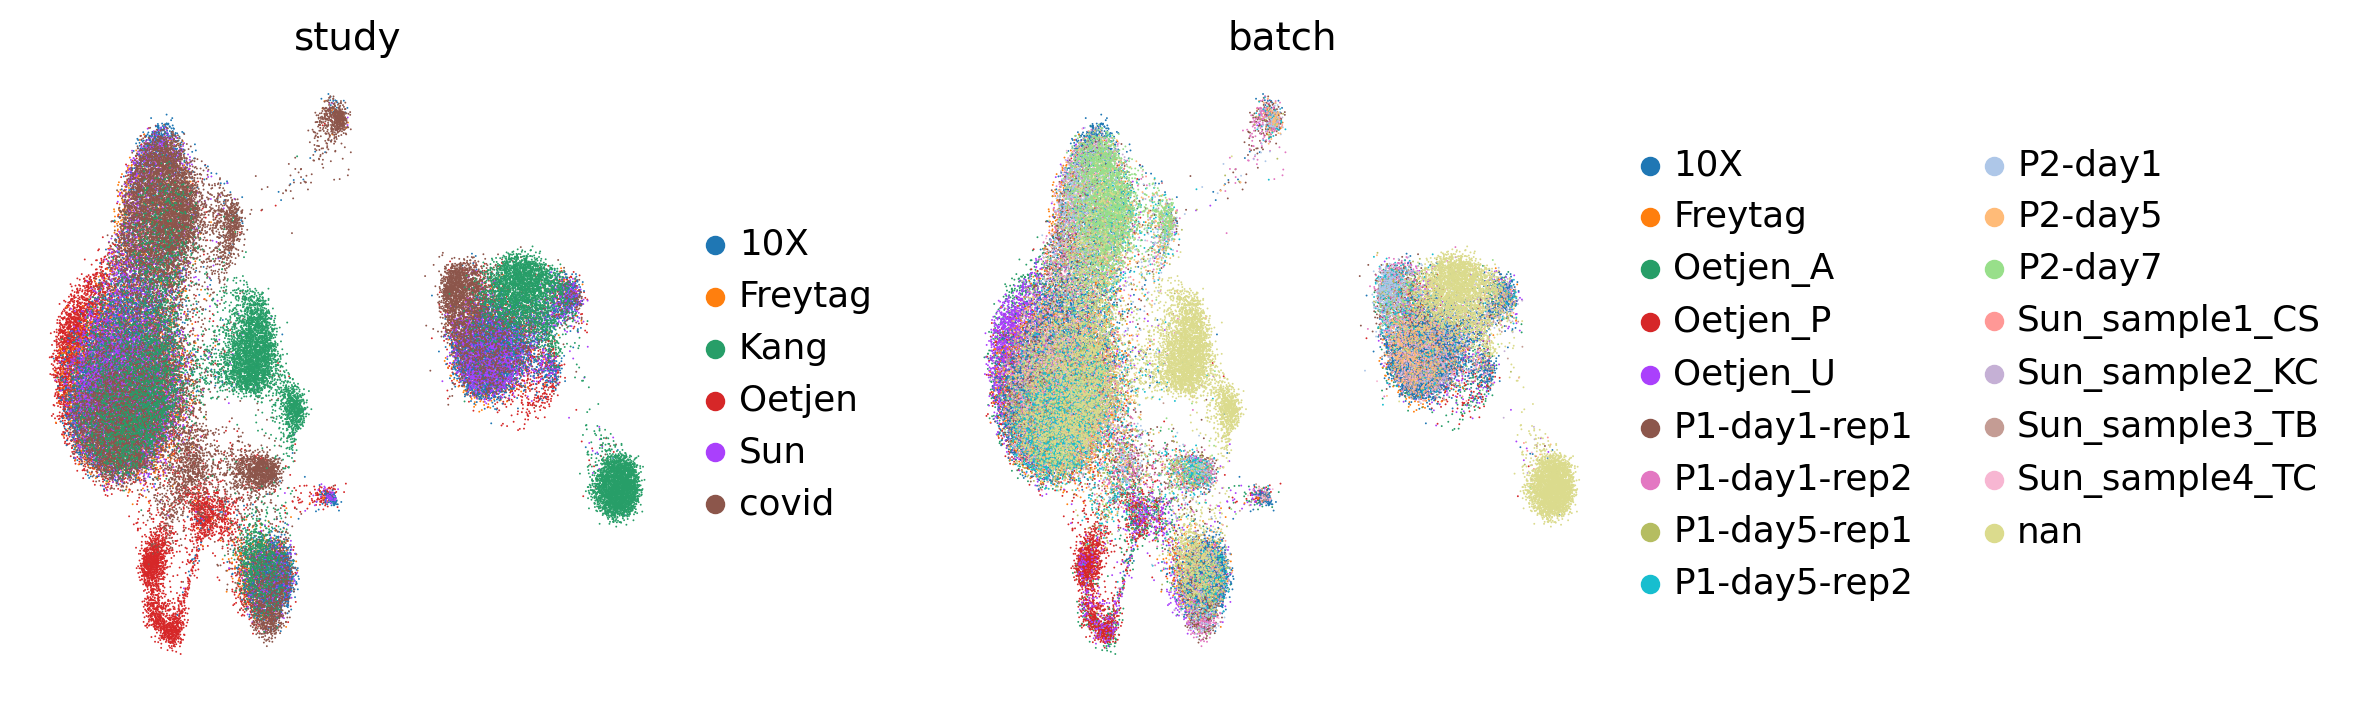

In [344]:
sc.pl.umap(covid_pbmc, color=['study', 'batch'], wspace=0.3)

In [345]:
covid_pbmc.obs['condition'] = covid_pbmc.obs['condition'].tolist()

In [346]:
covid_pbmc.obs['condition']

AAACCTGCAGCGAACA-1-Oetjen_A-0           nan
AAACCTGCATGTCCTC-1-Oetjen_A-0           nan
AAACCTGGTCGACTGC-1-Oetjen_A-0           nan
AAACCTGGTCGCTTCT-1-Oetjen_A-0           nan
AAACCTGTCCCGACTT-1-Oetjen_A-0           nan
                                    ...    
TTTGCATGAACGAA.1-1-1             stimulated
TTTGCATGACGTAC.1-1-1             stimulated
TTTGCATGCCTGTC.1-1-1             stimulated
TTTGCATGCTAAGC.1-1-1             stimulated
TTTGCATGGGACGA.1-1-1             stimulated
Name: condition, Length: 64812, dtype: object

In [347]:
covid_pbmc.obs['condition'][covid_pbmc.obs.study == "covid"] = covid_pbmc[covid_pbmc.obs.study == "covid"].obs.batch.values

In [348]:
covid_pbmc.obs.condition = covid_pbmc.obs.condition.astype('category')

In [349]:
covid_pbmc.obs.condition.cat.categories

Index(['P1-day1-rep1', 'P1-day1-rep2', 'P1-day5-rep1', 'P1-day5-rep2',
       'P2-day1', 'P2-day5', 'P2-day7', 'control', 'nan', 'stimulated'],
      dtype='object')

In [350]:
covid_pbmc.rename_categories("condition", ['P1-day1-rep1', 'P1-day1-rep2', 'P1-day5-rep1', 'P1-day5-rep2',
       'P2-day1', 'P2-day5', 'P2-day7', 'control (query)', 'control (reference)', 'INF-Beta'],)

In [351]:
covid_pbmc.obs["source"] = list(covid_pbmc.obs.condition)

In [352]:
old = ['P1-day1-rep1', 'P1-day1-rep2', 'P1-day5-rep1', 'P1-day5-rep2',
       'P2-day1', 'P2-day5', 'P2-day7', 'control (query)', 'control (reference)', 'INF-Beta']

new = ['P1-day1 (query)', 'P1-day1 (query)', 'P1-day5 (query)', 'P1-day5 (query)',
       'P2-day1 (query)', 'P2-day5 (query)', 'P2-day7 (query)', 'control', 'control', 'INF-Beta']

trans = dict(zip(old,new))

In [353]:
old_cat = list(covid_pbmc.obs.condition)
for i,j in enumerate(old_cat):
    old_cat[i] = trans[j]

In [354]:
covid_pbmc.obs["source"] = old_cat

In [355]:
old = ['P1-day1-rep1', 'P1-day1-rep2', 'P1-day5-rep1', 'P1-day5-rep2',
       'P2-day1', 'P2-day5', 'P2-day7', 'control (query)', 'control (reference)', 'INF-Beta']

new = ['Severe (query)', 'Severe (query)', 'Remission (query)', 'Remission (query)',
       'Severe (query)', 'Remission (query)', 'Remission (query)', 'control', 'control', 'INF-Beta']

trans = dict(zip(old,new))

In [356]:
old_cat = list(covid_pbmc.obs.condition)
for i,j in enumerate(old_cat):
    old_cat[i] = trans[j]

In [357]:
covid_pbmc.obs["source2"] = old_cat

... storing 'source' as categorical
... storing 'source2' as categorical


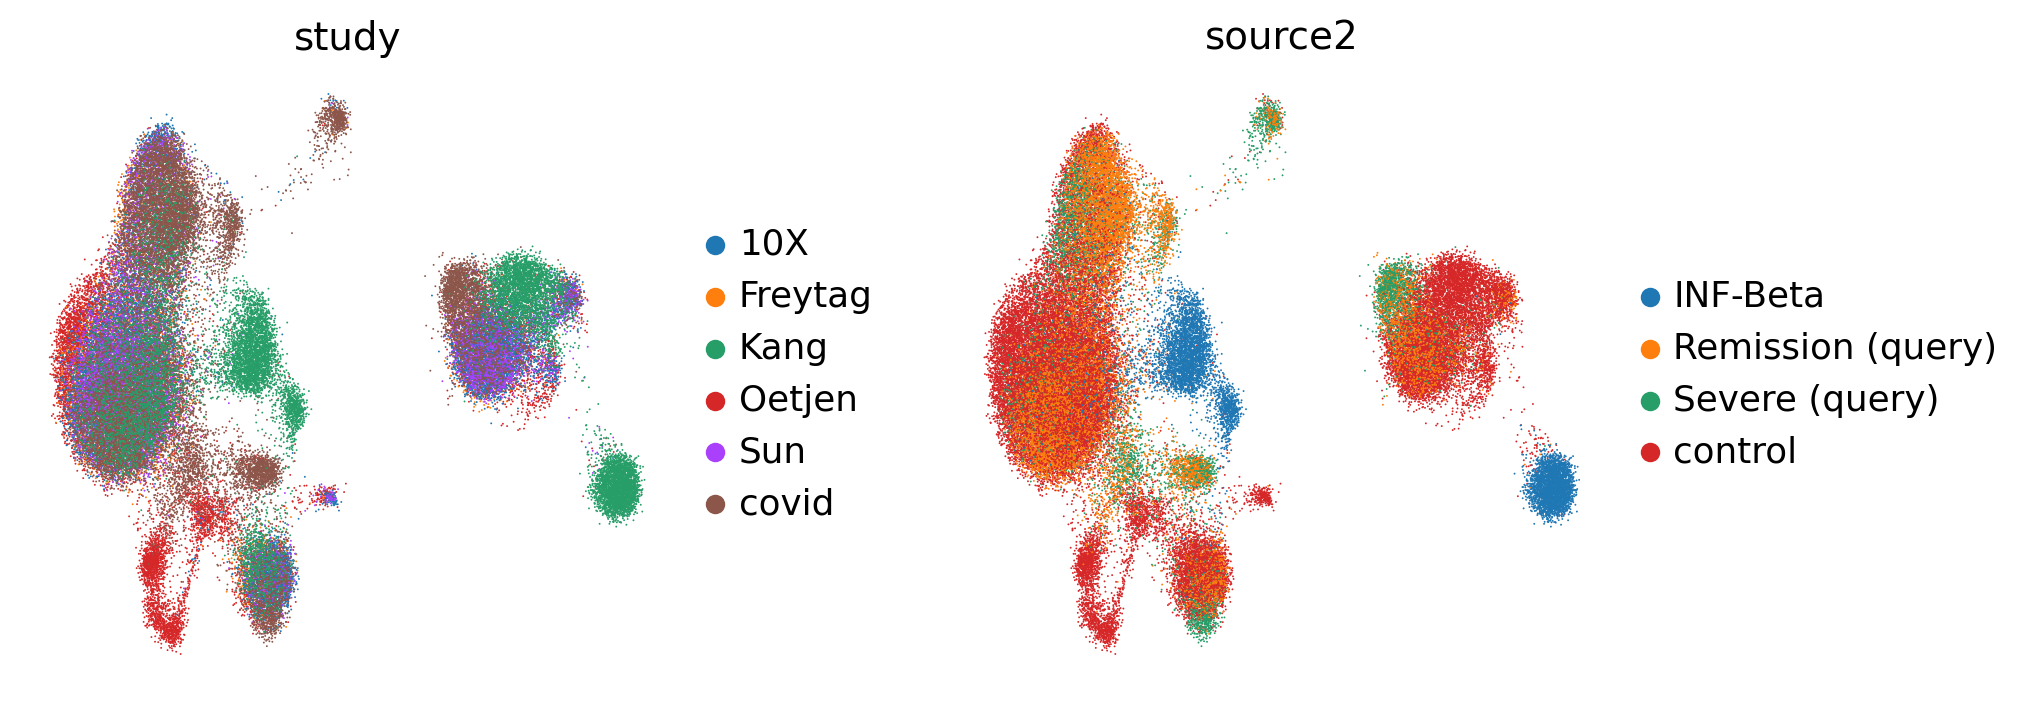

In [358]:
sc.pl.umap(covid_pbmc, color=['study', 'source2'], wspace=0.3)

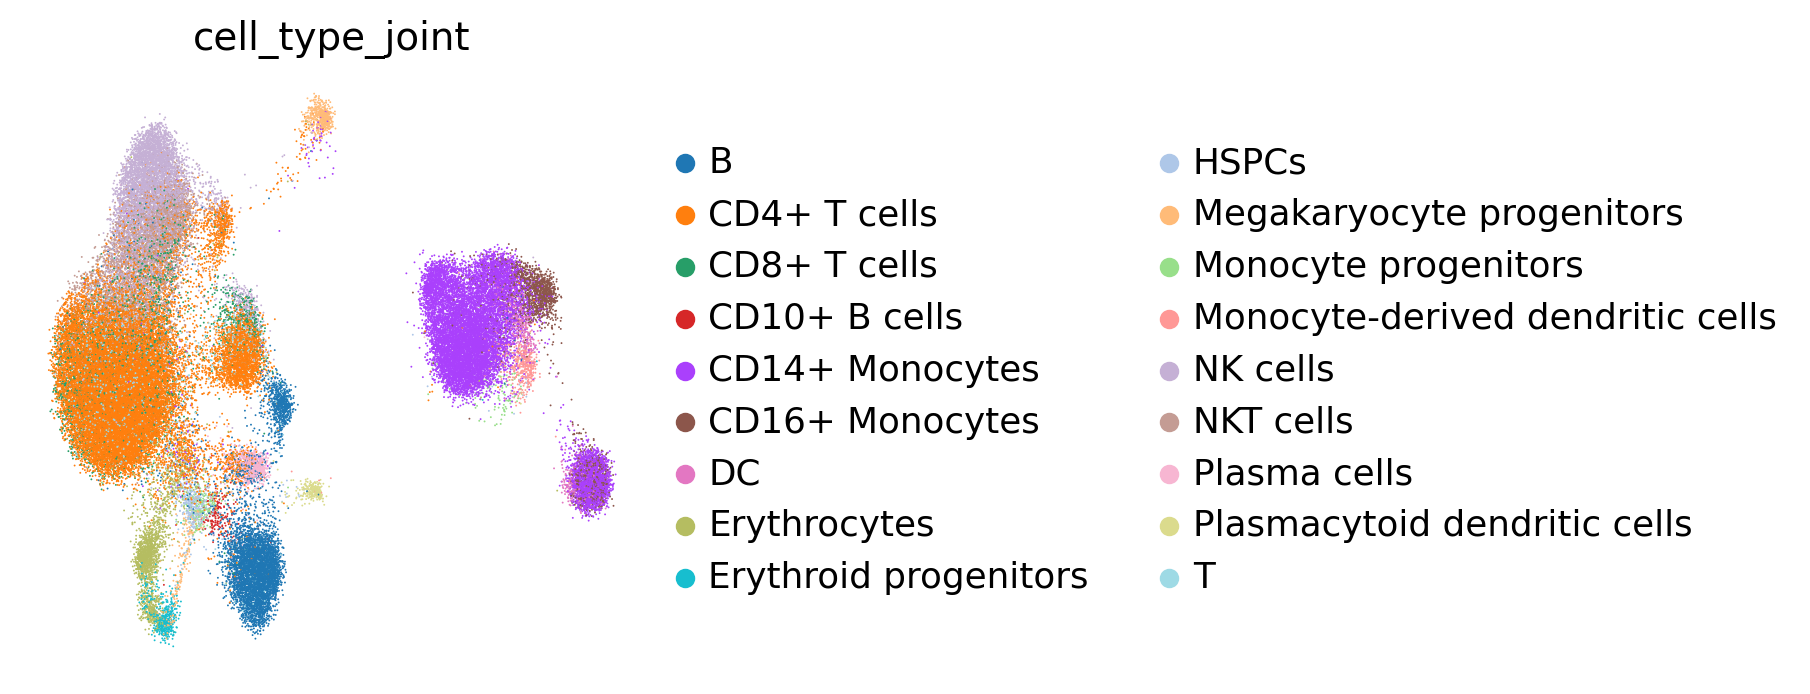

In [359]:
sc.pl.umap(covid_pbmc, color=['cell_type_joint'], wspace=0.3)

In [360]:
covid_pbmc.obs['celltype'] = list(covid_pbmc.obs['cell_type_joint'])

In [361]:
covid_pbmc.obs['celltype'][covid_pbmc.obs.study == "covid"] = "Unknown"

In [362]:
covid_pbmc.uns['terms'] = adata.uns['terms']

storing all genes 

In [364]:
ref = sc.read('../pbmc_kang/pbmc_vars_sb.h5ad')
ref = ref[ref.obs['study']!='Villani'].copy()
ref.X = ref.layers["counts"].copy()

In [365]:
covid = sc.read('covid_pbmc.h5ad')
kang = sc.read('../pbmc_kang/kang_count.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [366]:
covid.var_names_make_unique()
kang.var_names_make_unique()

In [367]:
covid_kang_raw = sc.AnnData.concatenate(covid, kang, batch_key='batch_join', join="outer")

In [368]:
covid_pbmc_raw = sc.AnnData.concatenate(ref, covid_kang, batch_key='batch_join', join="outer")

In [378]:
del covid_kang_raw

In [383]:
del covid_pbmc_raw

In [376]:
covid_pbmc.raw = covid_pbmc_raw[covid_pbmc.obs.index, :]

In [ ]:
sc.pl.umap(covid_pbmc, color=['study', 'source'], wspace=0.3)

In [384]:
covid_pbmc.write('covid_kang_pbmc_integrated_le.h5ad')

... storing 'celltype' as categorical
... storing 'ENS-0-1' as categorical
